In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import community as community_louvain
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import fa2_modified as fa2  # Import the modified version of ForceAtlas2

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


## Load processed graph

In [ ]:
# Path to your pickle file
pickle_file_path = "graphs/researchers_csai_graph_gcc.pkl"

with open(pickle_file_path, "rb") as f:
    G = pickle.load(f)

In [3]:
print(f'Graph has {len(G.nodes())} nodes')
print(f'Graph has {len(G.edges())} edges')

Graph has 162972 nodes
Graph has 2338729 edges


## Citations

In [4]:
# Dictionary to store unique titles and their citation counts
unique_citations = {}

# Iterate over all edges
for u, v, edge_data in G.edges(data=True):
    # Access title and citation count
    title = edge_data.get('title', None)
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    # Ensure title is valid (not None or empty)
    if title:
        if title not in unique_citations:
            unique_citations[title] = num_cited_by
        else:
            # If title is already seen, skip or handle duplicates (e.g., take max, sum, etc.)
            pass

# Count frequencies of citation counts
citation_freq = {}
for citation in unique_citations.values():
    if citation in citation_freq:
        citation_freq[citation] += 1
    else:
        citation_freq[citation] = 1

# Sort the citation frequencies by citation count (ascending order)
sorted_citation_freq = sorted(citation_freq.items())


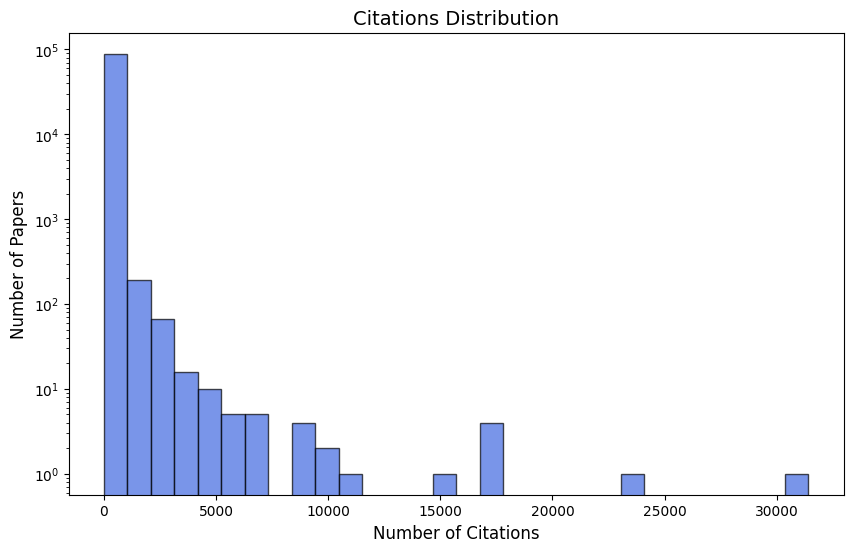

In [5]:
# Extract citation counts from the deduplicated data
deduplicated_citation_counts = list(unique_citations.values())

plt.figure(figsize=(10, 6))
plt.hist(
    deduplicated_citation_counts,
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")

plt.title("Citations Distribution", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)

plt.show()

As expected, we have a seriousely right-skewed citations distribution. Few papers enjoy very high number of citations and most papers get only a couple.

In [6]:
# Extract deduplicated citation data and associated paper metadata
deduplicated_paper_citations = [
    (title, num_cited_by) for title, num_cited_by in unique_citations.items()
]

# Sort papers by citation count in descending order
sorted_deduplicated_papers = sorted(
    deduplicated_paper_citations, key=lambda x: x[1], reverse=True
)

# Get the top 10 papers
top_10_papers = sorted_deduplicated_papers[:10]

# Print the top 10 papers
print("Top Papers with Most Citations (Deduplicated by Title):\n")
for i, (title, citations) in enumerate(top_10_papers, 1):
    print(f"{i}. {title} - Citations: {citations}")

Top Papers with Most Citations (Deduplicated by Title):

1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - Citations: 31414
2. SMOTE: Synthetic Minority Over-sampling Technique - Citations: 23278
3. A Unified Approach to Interpreting Model Predictions - Citations: 17703
4. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification - Citations: 17689
5. Graph Attention Networks - Citations: 17607
6. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization - Citations: 17416
7. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier - Citations: 15069
8. Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks - Citations: 10801
9. Conditional Generative Adversarial Nets - Citations: 9774
10. Training language models to follow instructions with human feedback - Citations: 9614


TO DO: 
- Do small research on them to tell a story. Looks like these are well aclaimed papers.

In [7]:
# Dictionary to store total citations for each researcher
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher
researcher_papers = defaultdict(set)

# Traverse edges to aggregate citation counts for each researcher
for u, v, edge_data in G.edges(data=True):
    # Access citation-related attributes and title
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)
    
    # Ensure the title is valid
    if title:
        # Add citations for each researcher, ensuring the paper is counted only once
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Sort researchers by total citations (descending)
sorted_researcher_citations = sorted(researcher_citations.items(), key=lambda x: x[1], reverse=True)

# Print the top researchers by total citations
print("Top Researchers by Total Citations (Deduplicated by Paper):\n")
for i, (researcher, total_citations) in enumerate(sorted_researcher_citations[:10], 1):  # Adjust the range for more/less
    print(f"{i}. {researcher} - Total Citations: {total_citations}")


Top Researchers by Total Citations (Deduplicated by Paper):

1. S. Levine - Total Citations: 66585
2. P. Abbeel - Total Citations: 59345
3. Alexey Dosovitskiy - Total Citations: 41593
4. Quoc V. Le - Total Citations: 38176
5. Lucas Beyer - Total Citations: 36650
6. Xiaohua Zhai - Total Citations: 36520
7. N. Houlsby - Total Citations: 36510
8. Alexander Kolesnikov - Total Citations: 36492
9. Mostafa Dehghani - Total Citations: 36346
10. Yoshua Bengio - Total Citations: 36330


TO DO: 
- Look into whether it is one or many papers for them. 
- Do small research for a story. 
- No women? - cover on that.

## Filter out low citations edges

From now on, we are focusing only on the most valuable papers judged by number of citations. We are filtering out papers with less than 25 citations.

In [15]:
# Find edges with below 25 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 25
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [16]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG = G_filtered.subgraph(giant_component).copy()

In [20]:
print(f'Filtered graph has {len(RG.nodes())} nodes')
print(f'Filtered graph has {len(RG.edges())} edges')

Filtered graph has 39314 nodes
Filtered graph has 1015840 edges


## Degree distribution

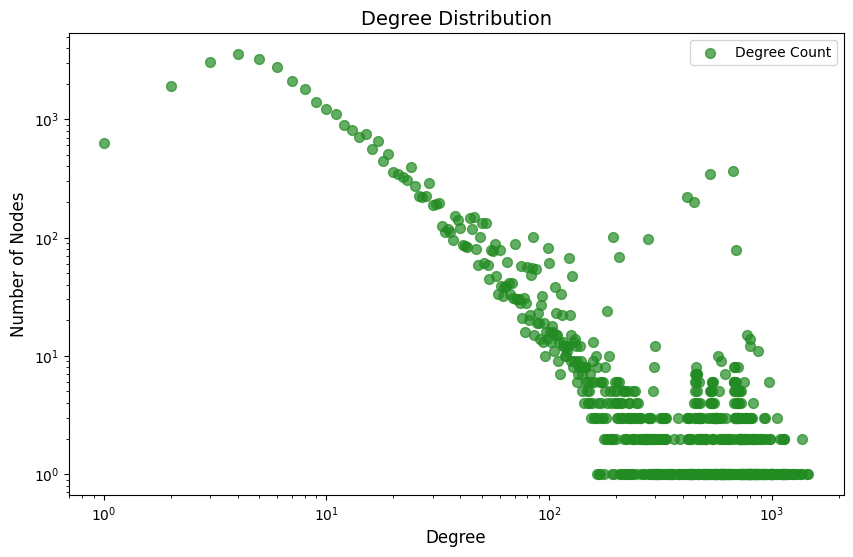

In [22]:
# Get the degree of each node
degrees = [d for _, d in RG.degree()]

# Count the frequency of each degree
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="forestgreen", alpha=0.7, s=50, label="Degree Count")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

Power-law degree distribution. We are dealing with scale-free network.

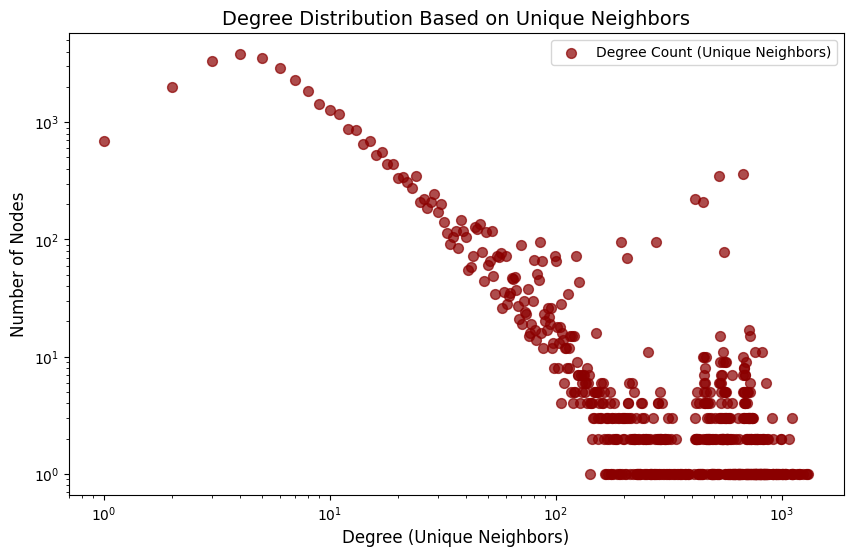

In [32]:
# Calculate degree based on unique neighbors
unique_neighbor_degrees = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Count the frequency of each degree
degree_counts = {}
for degree in unique_neighbor_degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="darkred", alpha=0.7, s=50, label="Degree Count (Unique Neighbors)")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution Based on Unique Neighbors", fontsize=14)
plt.xlabel("Degree (Unique Neighbors)", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

This second graph is calculated based on unique neighbours rather than number of edges. It does matter in case of MultiGraph but turns out the results are almost the same. This means that if we were to disregard multiple papers between two given researchers and just focus on whether they colaborated it wouldn't change the results in terms of degree.

TO DO: 
- In multigraphs, two nodes can have multiple edges between them. Check how it impacts the degree.
- Address the friendship paradox?

In [29]:
# Compute the degrees of all nodes
degrees = dict(RG.degree())

# Sort nodes by degree in descending order
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_degrees[:10]

# Display results
print("Top 10 nodes with highest degree:\n")
for node, degree in top_10_nodes:
    print(f"{node} - {degree}")

Top 10 nodes with highest degree:

Siamak Shakeri - 1462
Noah Fiedel - 1439
O. Vinyals - 1368
Ambrose Slone - 1368
Behnam Neyshabur - 1366
D. Hassabis - 1347
Michael B. Chang - 1344
Andrew M. Dai - 1285
Ethan Dyer - 1268
Vedant Misra - 1262


In [28]:
# Compute the number of unique neighbors for each node
unique_neighbors = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Sort nodes by the number of unique neighbors in descending order
sorted_unique_neighbors = sorted(unique_neighbors.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_unique_neighbors[:10]

# Display results
print("Top 10 nodes with the most unique neighbors:\n")
for node, count in top_10_nodes:
    print(f"{node} - {count}")

Top 10 nodes with the most unique neighbors:

Siamak Shakeri - 1311
Noah Fiedel - 1297
Behnam Neyshabur - 1283
Ambrose Slone - 1241
Andrew M. Dai - 1210
Ethan Dyer - 1193
Vedant Misra - 1191
Luheng He - 1171
Harsh Mehta - 1122
Rosanne Liu - 1119


Although both prints include similar reserachers the second print seems better for interpretation. It says that these researchers collaborated with the highest number of other researchers withing AI space.

TO DO:
- check if it is because of high average number of collaborations on paper or many papers

## Convert MultiGraph to regular Graph for some parts of analysis

In [41]:
# Convert the multigraph to a regular graph where two nodes can have only one edge
RG_regular = nx.Graph(RG)

In [42]:
print(f'RG Multigraph: \n Nodes: {len(RG.nodes())}\n Edges: {len(RG.edges())}\n')
print(f'RG Regular: \n Nodes: {len(RG_regular.nodes())}\n Edges: {len(RG_regular.edges())}')

RG Multigraph: 
 Nodes: 39314
 Edges: 1015840

RG Regular: 
 Nodes: 39314
 Edges: 942607


The difference in edges is very small and this explains why it does not matter whether we calulate degree based on number of edges or number of unique neighbours.

## Network Visualization

Below code should plot the whole network. It takes above 4h hours to run....

In [73]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions = forceatlas2.forceatlas2_networkx_layout(RG_regular, pos=None, iterations=1000)

  0%|          | 3/1000 [00:48<4:28:42, 16.17s/it]


KeyboardInterrupt: 

In [ ]:
# Prepare node colors based on node degree
node_degrees = [RG_regular.degree(node) for node in RG_regular.nodes]  # Get degree for each node
max_degree = max(node_degrees) if node_degrees else 1  # Normalize if node_degrees is empty
node_colors = [degree / max_degree for degree in node_degrees]  # Normalize degree for color scaling

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    RG_regular,
    pos=positions,  # Assuming positions are pre-calculated using ForceAtlas2
    node_color=node_colors,
    cmap=cm.viridis,       # Color map for nodes
    edge_color="gray",
    linewidths=0.5,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

# Create a colorbar with normalized node colors
sm = cm.ScalarMappable(cmap=cm.viridis)
sm.set_array(node_colors)  # Link color bar to node colors
fig.colorbar(sm, ax=ax, label="Normalized Node Degree")

# Set the title and show the plot
plt.title("Network Visualization", fontsize=14)
plt.show()

Trying to filter down the original MultiGraph network further.

In [77]:
# Find edges with below 50 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 100
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [78]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG_100 = G_filtered.subgraph(giant_component).copy()

In [80]:
# Convert the multigraph to a regular graph where two nodes can have only one edge
RG_100_regular = nx.Graph(RG_100)

In [81]:
print(f'Filtered graph has {len(RG_100_regular.nodes())} nodes')
print(f'Filtered graph has {len(RG_100_regular.edges())} edges')

Filtered graph has 14758 nodes
Filtered graph has 656903 edges


Trying to plot it now.

In [ ]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions = forceatlas2.forceatlas2_networkx_layout(RG_100_regular, pos=None, iterations=1000)

 14%|█▎        | 136/1000 [12:01<1:22:46,  5.75s/it]

In [ ]:
# Prepare node colors based on node degree
node_degrees = [RG_regular.degree(node) for node in RG_regular.nodes]  # Get degree for each node
max_degree = max(node_degrees) if node_degrees else 1  # Normalize if node_degrees is empty
node_colors = [degree / max_degree for degree in node_degrees]  # Normalize degree for color scaling

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    RG_regular,
    pos=positions,  # Assuming positions are pre-calculated using ForceAtlas2
    node_color=node_colors,
    cmap=cm.viridis,       # Color map for nodes
    edge_color="gray",
    linewidths=0.5,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

# Create a colorbar with normalized node colors
sm = cm.ScalarMappable(cmap=cm.viridis)
sm.set_array(node_colors)  # Link color bar to node colors
fig.colorbar(sm, ax=ax, label="Normalized Node Degree")

# Set the title and show the plot
plt.title("Network Visualization", fontsize=14)
plt.show()

## Clustering coefficient

In [43]:
# Compute the clustering coefficient for each node
node_clustering = nx.clustering(RG_regular)
average_clustering = nx.average_clustering(RG_regular)
print("Average Clustering Coefficient:", average_clustering)

Average Clustering Coefficient: 0.8164199181071512


In [49]:
# Compute the degree for each node
node_degrees = dict(RG_regular.degree())

# Prepare data for plotting
degrees = list(node_degrees.values())  # degree of each node
clustering_coeffs = list(node_clustering.values())  # clustering coefficient of each node

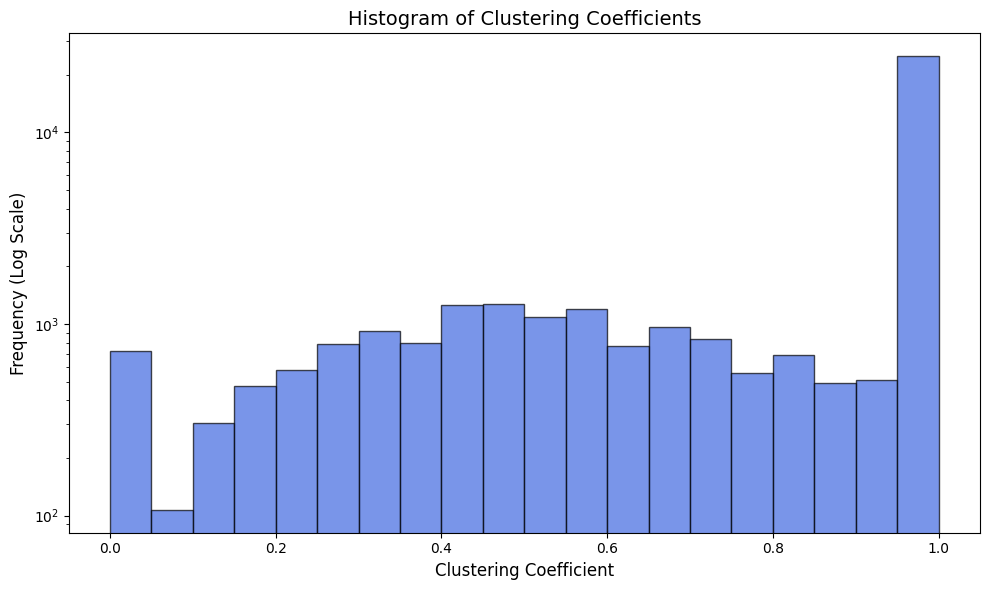

In [52]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color="royalblue", alpha=0.7, edgecolor="black")

# Set y-axis to logarithmic scale
plt.yscale("log")

# Title and labels
plt.title("Histogram of Clustering Coefficients", fontsize=14)
plt.xlabel("Clustering Coefficient", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Most researchers have a clustering coefficient close or equal to 1. It is however tricky to interpret in our case since if we have 20 researchers working on the same paper obviousely they will all be fully connected with each other.

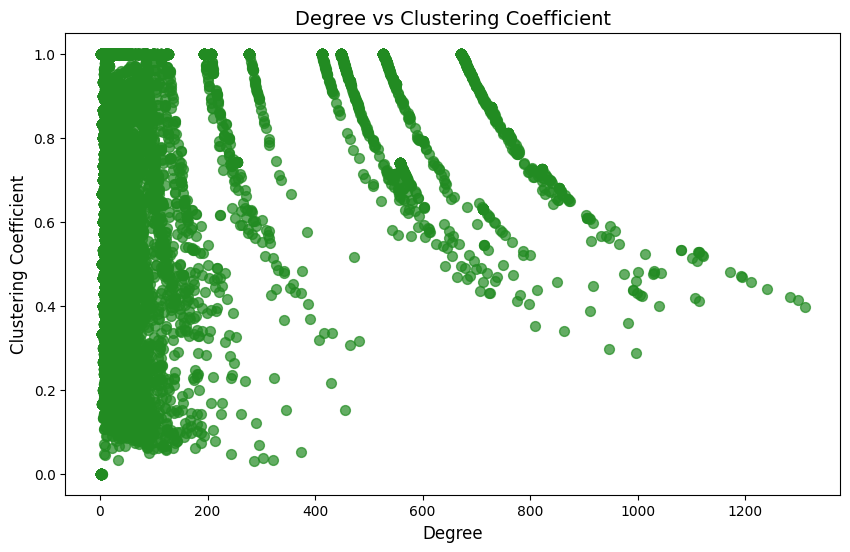

In [48]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, clustering_coeffs, color="forestgreen", alpha=0.7, s=50)

# Set the title and labels
plt.title("Degree vs Clustering Coefficient", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Clustering Coefficient", fontsize=12)

# Show the plot
plt.show()

What is a bit suprprising here is that researchers with high degree almost always have a high clustering coefficient. It might that those researchers enjoy high degree because of many people working on the same paper.

TO DO:
- check the reason for researchers having top degree levels

## Assortativity

In [53]:
assortativity = nx.degree_assortativity_coefficient(RG_regular)

# Print the result
print("Degree Assortativity Coefficient:", assortativity)

Degree Assortativity Coefficient: 0.7571716390313068


Very high degree assortativity. Typical for social networks. Maybe more so in reasearchs network.

TO DO:
- Think about whether we can get some interesting node attributes for our researchers based on which we could calculate assortativity. E.g. country, university, field of research typical? 

## Centrality

### Closeness Centrality

In [60]:
# Calculate closeness centrality for all nodes
closeness_centrality = nx.closeness_centrality(RG_regular)

# Get degree for each node
degrees = dict(RG_regular.degree())

# Prepare data for plotting
degree_values = list(degrees.values())
closeness_values = list(closeness_centrality.values())

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, closeness_values, color="royalblue", alpha=0.7)

# Title and labels
plt.title("Degree vs Closeness Centrality", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Closeness Centrality", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### Betweenness Centrality

In [ ]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(RG_regular)

# Get degree for each node
degrees = dict(RG_regular.degree())

# Prepare data for plotting
degree_values = list(degrees.values())
betweenness_values = list(betweenness_centrality.values())

# Create scatter plot for Degree vs Betweenness Centrality
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, color="forestgreen", alpha=0.7)

# Title and labels
plt.title("Degree vs Betweenness Centrality", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Betweenness Centrality", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Cliques

Placeholder for cliques analysis.

## Communities

In [66]:
# Find the best partition (communities)
partition = community_louvain.best_partition(RG_regular)

# Calculate the modularity of the partition
modularity = community_louvain.modularity(partition, RG_regular)

# Print the modularity score
print(f"Modularity: {modularity}")

Modularity: 0.7631779981763412


In [67]:
# Group nodes by community
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Calculate the total number of communities and average number of nodes
num_communities = len(communities)
node_counts = [len(nodes) for nodes in communities.values()]
average_nodes_per_community = sum(node_counts) / num_communities if num_communities > 0 else 0

# Print the summary
print(f"Total number of communities: {num_communities}")
print(f"Average number of nodes per community: {average_nodes_per_community:.2f}")

Total number of communities: 81
Average number of nodes per community: 485.36


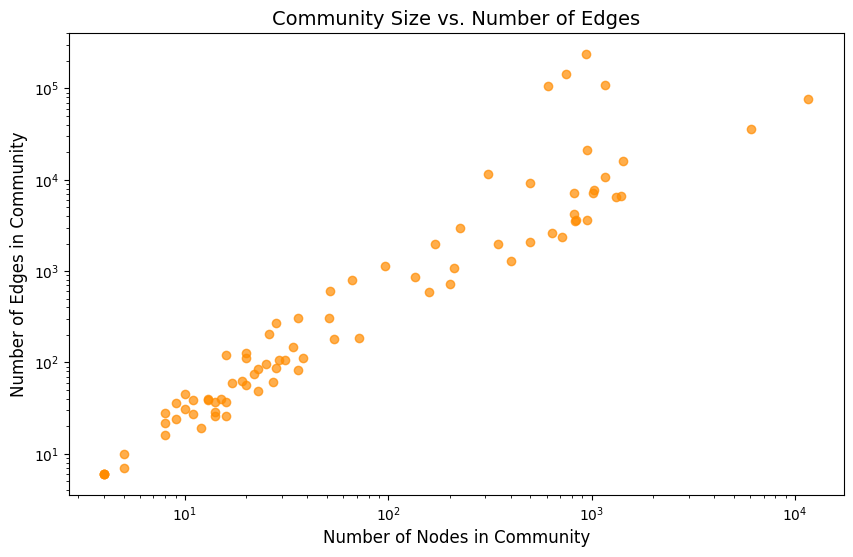

In [71]:
# Prepare data for plotting (nodes and edges)
edge_counts = []

# For each community, calculate the number of nodes and edges
for community_id, nodes in communities.items():
    num_nodes = len(nodes)
    
    # Count the number of edges within the community
    num_edges = 0
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if RG_regular.has_edge(nodes[i], nodes[j]):
                num_edges += 1
    
    # Store the values for the scatter plot
    edge_counts.append(num_edges)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(node_counts, edge_counts, color='darkorange', alpha=0.7)

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.title("Community Size vs. Number of Edges", fontsize=14)
plt.xlabel("Number of Nodes in Community", fontsize=12)
plt.ylabel("Number of Edges in Community", fontsize=12)

# Show the plot
plt.show()